# Todos:
- add algo with conservation score: see https://moodle.polytechnique.fr/mod/resource/view.php?id=388407 page 21, ask teacher for more details
- add benchmark to compare methods

# Evaluation:
- 30 min presentation in total for both projects
- submit code: Jupyter notebook (with explaination and run example/launch instructions)

### Necessary imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

import RNA
import Bio

import tempfile
from IPython.display import SVG, HTML, display

# Type hinting
from typing import List, Set, Union

### Utility functions

In [2]:
def standardize_sequence(x:str) -> str:
    ''' Setting all caracters to upper case and converting T to U '''
    string = x.upper()
    string = string.replace('T', 'U')
    return string

def pairs2db(seq_lenth:int, pairs:Set[tuple]) -> str:
    ''' Parse set of pairs to dot bracket string '''
    dbstring = ['.'] * seq_lenth
    for pair in pairs:
        a, b = pair
        if a > b:
            a, b = b, a
        dbstring[a] = '('
        dbstring[b] = ')'
    return ''.join(dbstring)

def db2pairs(dbstring:str) -> Set[tuple]:
    ''' Parse dot bracket string to pairs '''
    pairs = set()
    stack = []
    for i in range(len(dbstring)):
        if dbstring[i] == '(':
            stack.append(i)
        elif dbstring[i] == ')':
            if len(stack) == 0:
                raise ValueError("Unbalanced brackets")
            else: 
                pairs.add((stack.pop(),i))    
    if len(stack) != 0:
        raise ValueError("Unbalanced brackets")
    return pairs

def is_canonical_basepair(x:str, y:str) -> bool:
    ''' Check if a pair is canonical '''
    _complementary_bases = set(["AU","CG","GC","GU","UA","UG"])
    return x+y in _complementary_bases

def is_canonical(seq:str, dbstring:str) -> bool:
    ''' Check if all the pairs of a structure are canonical '''
    pairs = db2pairs(dbstring)
    for pair in pairs:
        if not is_canonical_basepair(seq[pair[0]-1], seq[pair[1]-1]):
            return False
    return True

In [3]:
from Bio import AlignIO

def read_file(filename, filetype=None, verbose=False):
    if filetype is None:
        if filename.split('.')[-1] == 'aln':
            filetype = 'clustal'
        elif filename.split('.')[-1] == 'stk':  
            filetype = 'stockholm'
        else:
            raise ValueError("File type not recognized")
    align = AlignIO.read(filename, filetype)
    if verbose: 
        print(f"filetype: {filetype}")
        print(align)
    return align

In [4]:
# test
alignment = read_file('data/Testdata/tRNA_7.stk', verbose=True)

print(alignment[0].seq)
print()

alignment_list = [str(record.seq) for record in alignment]
print(alignment_list)

filetype: stockholm
Alignment with 7 rows and 85 columns
GCAGUCGUGGCCGAGU---GGUUAAGGCGUCUGACUCGAAAUCA...GCG AC021639.5_181586-181505
GCGGGGGUGCCCGAGCCUGGCCAAAGGGGUCGGGCUCAGGACCC...GCA AP000063.1_59179-59095
UGGAGUAUAGCCAAG--UGG--UAAGGCAUCGGUUUUUGGUACC...CAG AP000397.1_114390-114319
CGGAAAGUAGCUUAGCUUGG--UAGAGCACUCGGUUUGGGACCG...CGA X03715.1_388-461
GCCGGGGUGGGGUAGUGGCCAUCCUGG---GGGACUGUGGAUCC...GCC U67517.1_7511-7582
GUAAACAUAGUUUA------AUCAAAACAUUAGAUUGUGAAUCU...ACC X99256.1_11558-11626
AGUAAAGUCAGCUA------AAAAAGCUUUUGGGCCCAUACCCC...CUA M10217.1_5910-5978
GCAGUCGUGGCCGAGU---GGUUAAGGCGUCUGACUCGAAAUCAGAUUCCCUCUGGGAGCGUAGGUUCGAAUCCUACCGGCUGCG

['GCAGUCGUGGCCGAGU---GGUUAAGGCGUCUGACUCGAAAUCAGAUUCCCUCUGGGAGCGUAGGUUCGAAUCCUACCGGCUGCG', 'GCGGGGGUGCCCGAGCCUGGCCAAAGGGGUCGGGCUCAGGACCCGAUGGCGUAGGCCUGCGUGGGUUCAAAUCCCACCCCCCGCA', 'UGGAGUAUAGCCAAG--UGG--UAAGGCAUCGGUUUUUGGUACCG---------GCAUGCAAAGGUUCGAAUCCUUUUACUCCAG', 'CGGAAAGUAGCUUAGCUUGG--UAGAGCACUCGGUUUGGGACCGA---------GGGGUCGCAGGUUCGAAUCCUGUCUUU

### RnaMolecule class
A class for molecules that contains the sequence and the according structrure

In [5]:
class RnaMolecule:
    ''' Class to represent RNA molecule with sequence and structure

    Properties
    ----------
    sequence: str
        sequence of the molecule
    dbstring: str
        dot bracket string of the structure
    pairs: set
        set of pairs of the structure
    bpp: tupple of tuple
        base pair probability matrix. !!! the indices start at 1 (first line and column are 0)
    '''
    def __init__(self, sequence:str, structure=None):
        """
        Initialises an instance

        Args:
            sequence: str, sequence of the molecule
            structure: dbstring or set of pairs of the structure, optionnal
        """
        self.sequence = standardize_sequence(sequence)
        if structure is None:
            self.dbstring = '.' * len(sequence)
            self.pairs = set()
        elif type(structure) == str:
            self.dbstring = structure
            self.pairs = db2pairs(structure)
        elif type(structure) == set:   
            self.pairs = structure
            self.dbstring = pairs2db(len(sequence), structure)
        self.bpp = None

    def set_structure(self, structure=None):
        ''' Set the structure of the molecule
        If no structure is given, the MFE structure is computed with VieannaRNA'''
        if structure is None:
            model = RNA.md()
            model.uniq_ML = 1  # activate unique multibranch loop decomposition    
            fold_compound = RNA.fold_compound(self.sequence, model)
            structure, energy = fold_compound.mfe()
            fold_compound.exp_params_rescale(energy)
            fold_compound.pf()    # compute partition function to fill DP matrices

            self.bpp = fold_compound.bpp()

        if type(structure) == str:
            self.dbstring = structure
            self.pairs = db2pairs(structure)
        elif type(structure) == set:   
            self.pairs = structure
            self.dbstring = pairs2db(len(self.sequence), structure)
            
    
    def __str__(self):
        return f"RnaMolecule({self.sequence}, {self.dbstring})"

    def plot(self):
        ''' Plot the structure of the RNA molecule '''
        fp = tempfile.NamedTemporaryFile(suffix="svg")
        RNA.svg_rna_plot(self.sequence, structure=self.dbstring, ssfile=fp.name)
        display(SVG(fp.name))
    
    def plot_bpp(self):
        if self.bpp is None:
            print("bpp has not been computed")
            return
        bpp2 = [[math.sqrt(p)  for p in row[1:]]for row in self.bpp[1:]] # why use sqrt: only for better visualization of small values ?
        plt.imshow(bpp2)
        plt.title("base pair probability")
        plt.show()
        unp = [1-sum(self.bpp[i][j] + self.bpp[j][i] for j in range(1,len(self.bpp))) for i in range(1,len(self.bpp))]
        plt.plot(unp)
        plt.title("probability to be unpaired")
        plt.show()

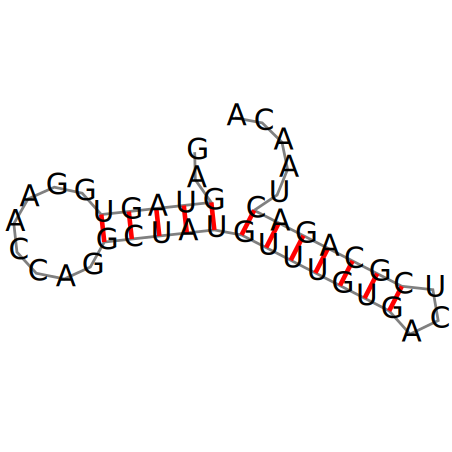

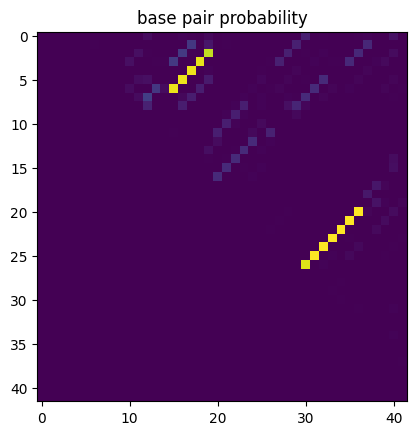

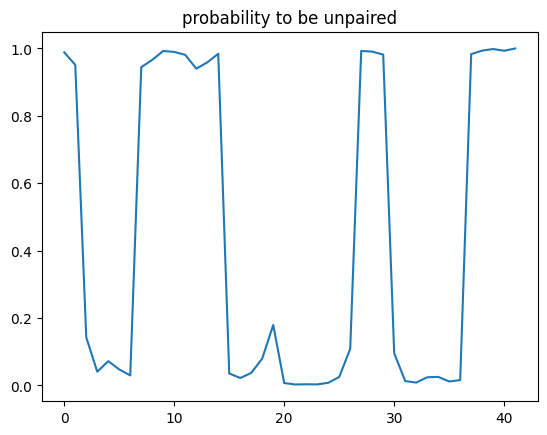

In [6]:
# test
sequence = "GAGUAGUGGAACCAGGCUAUGUUUGUGACUCGCAGACUAACA"

mol = RnaMolecule(sequence)
mol.set_structure()
mol.plot()
mol.plot_bpp()

# Computing the structure of an alignment

### Using the ViennaRNA package
ViennaRNA can predict the structure of a sequence or of an alignment, by minimizing the folding energy.

In [7]:
def predict_structure_mfe(sequence: Union[str, List[str]]) -> str:
    model = RNA.md()
    model.uniq_ML = 1  # activate unique multibranch loop decomposition    
    fold_compound = RNA.fold_compound(sequence, model)
    structure, energy = fold_compound.mfe()
    fold_compound.exp_params_rescale(energy)
    fold_compound.pf()    # compute partition function to fill DP matrices
    return structure

# Nussinov algorithm

Given an RNA sequence $S$, the Nussinov algorithm computes the maximum number of basepairs in any of its non-crossing RNA secondary structures. By dynamic programming the algorithm computes the maximum number of base pairs in structures of all of its subsequences $S_i,\dots,S_j$ and stores them at matrix entries $M_{i,j}$.

$M_{i,j}$ is defined by the following initialisation: $ \forall j − i \leq \text{min\_loop}: \quad M_{i,j} = \text{unpaired\_score}(i,j) $


and the following the following reccursion formula:
$$
\forall 1 \leq i < j \leq n, \quad j − i > \text{min\_loop}: \qquad
M_{i,j} = \max \begin{cases}
  M_{i+1,j-1} + \text{paired\_accuracy}(i,j) & \text{ if $S_i$ and $S_j$ compl.} \\
  \max_{i \leq k< j} M_{i,k}+ M_{k+1,j}
\end{cases}
$$

In [8]:
def compute_matrix(alignment:List[RnaMolecule], n, unpaired_score, paired_score, min_loop=1)->np.array:
    '''Predict folding of RNA alignement using modified Nussinov algorithm'''

    M = np.zeros((n, n))

    # initialize the matrix
    for i in range(n):
        for j in range(i, min(n,i+min_loop+1)):
            M[i][j] = unpaired_score(alignment, i)
    # fill the matrix
    for i in reversed(range(n)):
        for j in range(i+min_loop+1, n):
            M[i][j] = max([M[i,k] + M[k+1,j] for k in range(i, j)])
            M[i][j] = max(M[i][j], M[i+1,j-1] + paired_score(alignment, i, j))
    return M

def traceback_matrix(alignment:List[RnaMolecule], n, paired_score, M:np.array, min_loop:int) -> list:
    '''Traceback the modified Nussinov matrix to find the pairs'''
     
    def traceback_position(i,j):
        pairs = []
        while j-i >= min_loop:
            if M[i][j] == M[i+1][j-1] + paired_score(alignment, i, j):
                pairs.append((i,j))
                i += 1
                j -= 1
            elif M[i][j] == M[i+1][j]:  # not necessary, but avoids some recurisve calls
                i += 1
            elif M[i][j] == M[i][j-1]:
                j -= 1
            else:
                for k in range(i, j):
                    if M[i][j] == M[i][k] + M[k+1][j]:
                        pairs += traceback_position(i, k)
                        pairs += traceback_position(k+1, j)
                        return pairs
        return pairs

    return traceback_position(0, n-1)

def predict_structure(alignment:List[RnaMolecule], unpaired_score, paired_score, min_loop=1)->str:
    '''Predict the consensus structure of an alignment'''

    if type(alignment[0]) == str:
        n = len(alignment)
    elif type(alignment[0]) == RnaMolecule:
        n = len(alignment[0].sequence)
    
    M = compute_matrix(alignment, n, unpaired_score, paired_score, min_loop)
    pairs = traceback_matrix(alignment, n, paired_score, M, min_loop)
    return pairs2db(n, pairs)

### Standard version: maximum of matched pairs
The basic version of the Nussinov algorithm tries to maximise the number of matched pairs. This means we use the following score:

In [9]:
def unpaired_score_simple(sequence:str, i:int)->float:
    return 0

def paired_score_simple(sequence:str, i:int, j:int, l=1)->float:
    if is_canonical_basepair(sequence[i], sequence[j]):
        return 1
    return 0

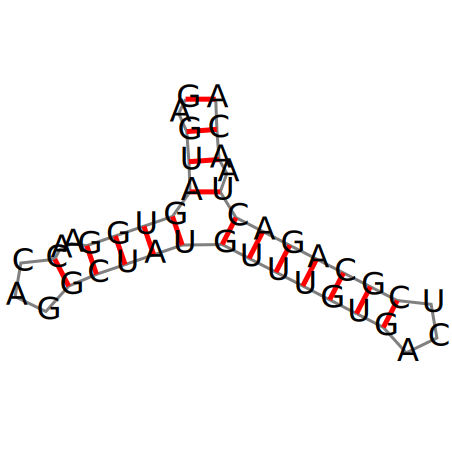

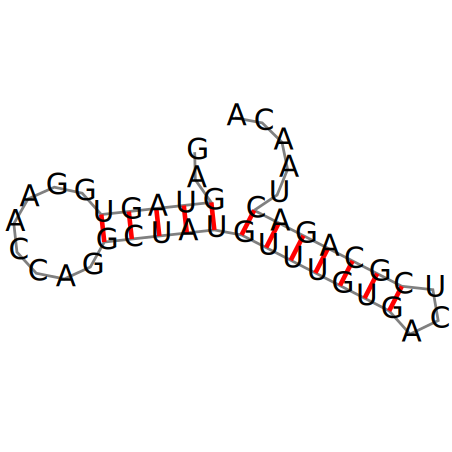

In [10]:
# test: on a single sequence
sequence = "GAGUAGUGGAACCAGGCUAUGUUUGUGACUCGCAGACUAACA"

db = predict_structure(sequence, unpaired_score_simple, paired_score_simple, min_loop=3)
mol = RnaMolecule(sequence, db)
mol.plot()

db2 = predict_structure_mfe(sequence)
mol2 = RnaMolecule(sequence, db2)
mol2.plot()

### Using MTA: Maximum total accuracy
Given an alignment and the list of corresponding structures, we try to find the consensus structure that maximises the agreement with all the given structures.

The agreement of two structures R and R' is mesured by their accuracy:
$$Acc(R,R')= 2λ|R ∩ R'| + |R^u ∩ R'^u |$$
R and R' beeing the set of pairs, and $R^u$ and $R'^u$ the set of unpaired positions.

In [11]:
def unpaired_accuracy_MTA(alignment:List[RnaMolecule], i:int)->float:
    '''Compute the unpaired accuracy of a structure'''
    unpaired = 0
    for mol in alignment:
        if mol.dbstring[i] == '.':
            unpaired += 1
    return unpaired

def paired_accuracy_MTA(alignment:List[RnaMolecule], i:int, j:int, l=1)->float:
    '''Compute the paired accuracy of a structure'''
    paired = 0
    for mol in alignment:
        if (i,j) in mol.pairs or (j,i) in mol.pairs:
            paired += 1
    return 2*l*paired

In [12]:
# test: on an easy alignment
seq = ["GC-C-AAA-GGC", "GGGC-AUU-GCC", "AC-GGAAUCCGU"]
db = ["((-(-...-)))", "((.(-...-)))", "((-((...))))"]

alignment = []
for i in range(len(seq)):
    alignment.append(RnaMolecule(seq[i],db[i]))
    print(db[i])

print(12*'_')
mta = predict_structure(alignment, unpaired_accuracy_MTA, paired_accuracy_MTA, 1)
print(mta)

((-(-...-)))
((.(-...-)))
((-((...))))
____________
((.(.....)))


### Using MEA: Maximum expected accuracy
For this, we need the base pair probability given by the Vienna package with `fc.bpp()`.

In [13]:
def unpaired_accuracy_MEA(alignment:List[RnaMolecule], i:int)->float:
    '''Compute the unpaired accuracy of a structure'''
    unpaired = 0
    for mol in alignment:
        unpaired += 1-sum(mol.bpp[i][j] + mol.bpp[j][i] for j in range(1,len(mol.bpp)))
    return unpaired

def paired_accuracy_MEA(alignment:List[RnaMolecule], i:int, j:int, l=1)->float:
    '''Compute the paired accuracy of a structure'''
    paired = 0
    for mol in alignment:
        paired += mol.bpp[i+1][j+1]
    return 2*l*paired

### Using conservation score
We add a bonus to the structure if two pairs have covariated to stay complementary:
$$
\delta_{cov}(i,j) = 1/2 \sum_{A, A' \in alignment} \begin{cases}
  1(A_i \neq A'_i) + 1(A_j \neq A'_j)  & \text{ if $A_i, A_j$ and $A'_i, A'_j$ compl.} \\
  0 & \text{otherwise}
\end{cases}
$$

and a malus if the matched pairs are not complementary:
$$
\delta_{inc}(i,j) = 1/2 \sum_{A \in alignment} \begin{cases}
  0 & \text{ if $A_i, A_j$ compl.} \\
  -0.25 & \text{ if $A_i, A_j$ gaps} \\
  -1 & \text{otherwise}
\end{cases}
$$

This measure can be combined with the MTA or the MEA to get a consensus alignment.

In [14]:
def delta_cov(alignment:List[RnaMolecule], i:int, j:int)->float:
    '''Compute the covariance bonus'''
    res = 0
    n = len(alignment)
    for a in range(n):
        if is_canonical_basepair(alignment[a].sequence[i], alignment[a].sequence[j]):
            for b in range(a+1, n):
                if is_canonical_basepair(alignment[b].sequence[i], alignment[b].sequence[j]):
                    if alignment[a].sequence[i] != alignment[b].sequence[i]:
                        res += 1
                    if alignment[a].sequence[j] != alignment[b].sequence[j]:
                        res += 1
    return res/2

def delta_inc(alignment:List[RnaMolecule], i:int, j:int)->float:
    '''Compute the incompaty malus'''
    res = 0
    for mol in alignment:
        if is_canonical_basepair(mol.sequence[i], mol.sequence[j]):
            res += 0
        elif mol.sequence[i] == '-' and mol.sequence[j] == '-':
            res += 0.25
        else:
            res += 1
    return -res

def unpaired_MEA_with_conservation(alignment:List[RnaMolecule], i:int)->float:
    '''Compute the unpaired accuracy of a structure'''
    return unpaired_accuracy_MEA(alignment, i)

def paired_MEA_with_conservation(alignment:List[RnaMolecule], i:int, j:int, l=1)->float:
    '''Compute the paired accuracy of a structure'''
    return paired_accuracy_MEA(alignment, i, j, l) + delta_cov(alignment, i, j) + delta_inc(alignment, i, j)

In [15]:
# test: on a real example
sequences = read_file('data/Testdata/tRNA_7.stk')
sequences = [str(record.seq) for record in sequences]

alignment = []
for seq in sequences:
    mol = RnaMolecule(seq)
    mol.set_structure()
    alignment.append(mol)

for mol in alignment:
    print(mol.dbstring)

print(len(alignment[0].sequence)*'_')

mta = predict_structure(alignment, unpaired_accuracy_MTA, paired_accuracy_MTA, min_loop=1)
print(mta)

mea = predict_structure(alignment, unpaired_accuracy_MEA, paired_accuracy_MEA, min_loop=1)
print(mea)

mcs = predict_structure(alignment, unpaired_MEA_with_conservation, paired_MEA_with_conservation, min_loop=1)
print(mcs)

mfe = predict_structure_mfe(sequences) # mfe from ViennaRNA also works directly for alignments
print(mfe)


(((((((..(((.............)))((((((.......))))))((((...))))..(((((.......)))))))))))).
(((((((..((.((((((((((.....)))))))))).)).......(((....)))...(((((.......)))))))))))).
(((((((...(((....)))......((((((((.......))))...........))))(((((.......)))))))))))).
((((((((((....((((......))))..((((.(((.((((.............)))).)))..))))...))).))))))).
.(((((((((........)))))))))...((((((((((((((..................))))))).....)))))))....
.....(((((((((................))))))))).....................(((((.......)))))........
(((((((..((((...........)))).(((((.......))))).................(((...))).....))))))).
_____________________________________________________________________________________
(((((((.......................((((.......))))...............(((((.......)))))))))))).
(((((((.......................((((.......))))................(((.........))).))))))).
(((((((..(((.............)))..((((.......))))...............((((.........))))))))))).
(((((((..(((.............)))..((((.......)))).........